## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.classify import NaiveBayesClassifier
import numpy as np
import re
import string
import nltk
%matplotlib inline

In [2]:
temp = pd.read_csv('../archive/1429_1.csv')

/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/2101804219.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv('../archive/1429_1.csv')


In [3]:
permanent = temp[['reviews.rating' , 'reviews.text' , 'reviews.title' , 'reviews.username']]
print(permanent.isnull().sum()) #Checking for null values
permanent.head()


reviews.rating      33
reviews.text         1
reviews.title        6
reviews.username     7
dtype: int64


,reviews.rating,reviews.text,reviews.title,reviews.username
0,5.0,This product so far has not disappointed. My c...,Kindle,Adapter
1,5.0,great for beginner or experienced person. Boug...,very fast,truman
2,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ
3,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks
4,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42


## Filtering null values

In [4]:
check =  permanent[permanent["reviews.rating"].isnull()]
check.head()

,reviews.rating,reviews.text,reviews.title,reviews.username
2886,NaN,The Kindle is my first e-ink reader. I own an ...,"Worth the money. Not perfect, but very very go...",Jeffrey Stanley
2887,NaN,"I'm a first-time Kindle owner, so I have nothi...","I Wanted a Dedicated E-Reader, and That's What...",Matthew Coenen
2888,NaN,UPDATE NOVEMBER 2011:My review is now over a y...,Kindle vs. Nook (updated),Ron Cronovich
2889,NaN,"I'm a first-time Kindle owner, so I have nothi...","I Wanted a Dedicated E-Reader, and That's What...",Matthew Coenen
2890,NaN,I woke up to a nice surprise this morning: a n...,"Not the perfect do-it-all device, but very clo...",C. Tipton


## Filtering not null values

In [5]:
senti= permanent[permanent["reviews.rating"].notnull()]
permanent.head()

,reviews.rating,reviews.text,reviews.title,reviews.username
0,5.0,This product so far has not disappointed. My c...,Kindle,Adapter
1,5.0,great for beginner or experienced person. Boug...,very fast,truman
2,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ
3,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks
4,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42


## Classifying text as postive and negative

In [6]:
senti["senti"] = senti["reviews.rating"]>=4
senti["senti"] = senti["senti"].replace([True , False] , ["pos" , "neg"])

/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/2314567631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti["senti"] = senti["reviews.rating"]>=4
/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/2314567631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti["senti"] = senti["senti"].replace([True , False] , ["pos" , "neg"])


## Count of reviews

<Axes: xlabel='senti'>

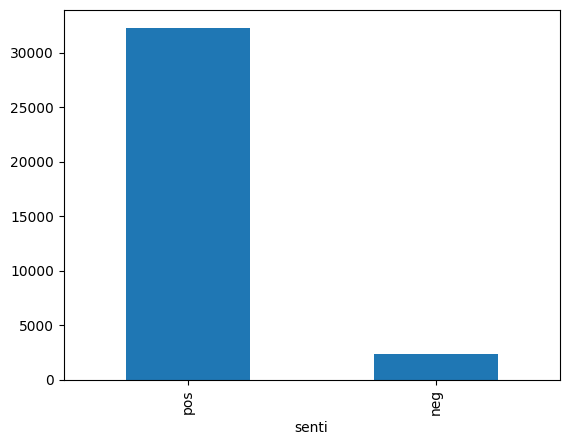

In [7]:
senti["senti"].value_counts().plot.bar()

As we can see data is unbalanced so this will create problem for model but, will take this data as it is and will predict our reviews.

## Cleaning text

In [8]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import numpy as np
import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

senti["Summary_Clean"] = senti["reviews.text"].apply(cleanup)
check["Summary_Clean"] = check["reviews.text"].apply(cleanup)


/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/326817876.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti["Summary_Clean"] = senti["reviews.text"].apply(cleanup)
/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/326817876.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check["Summary_Clean"] = check["reviews.text"].apply(cleanup)


## Splitting Train and Test Data

In [9]:
split = senti[["Summary_Clean" , "senti"]]
train=split.sample(frac=0.8,random_state=200)
test=split.drop(train.index)

## Feature Extracter for NLTK Naive bayes classifier

In [10]:
def word_feats(words):
    features = {}
    for word in words:
        features [word] = True
    return features


In [11]:
train["words"] = train["Summary_Clean"].str.lower().str.split()
test["words"] = test["Summary_Clean"].str.lower().str.split()
check["words"] = check["Summary_Clean"].str.lower().str.split()

train.index = range(train.shape[0])
test.index = range(test.shape[0])
check.index = range(check.shape[0])
prediction =  {} ## For storing results of different classifiers

train_naive = []
test_naive = []
check_naive = []

for i in range(train.shape[0]):
    train_naive = train_naive +[[word_feats(train["words"][i]) , train["senti"][i]]]
for i in range(test.shape[0]):
    test_naive = test_naive +[[word_feats(test["words"][i]) , test["senti"][i]]]
for i in range(check.shape[0]):
    check_naive = check_naive +[word_feats(check["words"][i])]


classifier = NaiveBayesClassifier.train(train_naive)
print("NLTK Naive bayes Accuracy : {}".format(nltk.classify.util.accuracy(classifier , test_naive)))
classifier.show_most_informative_features(5)


/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/4101619875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check["words"] = check["Summary_Clean"].str.lower().str.split()


NLTK Naive bayes Accuracy : 0.5897472924187726
Most Informative Features
                 deleted = True              neg : pos    =     51.3 : 1.0
                 warning = True              neg : pos    =     51.3 : 1.0
                    bent = True              neg : pos    =     42.0 : 1.0
                    nope = True              neg : pos    =     42.0 : 1.0
                  rotate = True              neg : pos    =     42.0 : 1.0


## predicting result of nltk classifier

In [12]:
y =[]
only_words= [test_naive[i][0] for i in range(test.shape[0])]
for i in range(test.shape[0]):
    y = y + [classifier.classify(only_words[i] )]
prediction["Naive"]= np.asarray(y)

y1 = []
for i in range(check.shape[0]):
    y1 = y1 + [classifier.classify(check_naive[i] )]

check["Naive"] = y1

/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/4099987593.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check["Naive"] = y1


## Now we are bulding Countvector and Tfidf vector for train , test ,check data

In [13]:
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

# Fix: Convert set to list
stopwords = list(set(STOPWORDS))
stopwords.remove("not")

count_vect = CountVectorizer(min_df=2, stop_words=stopwords, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(train["Summary_Clean"])        
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

checkcounts = count_vect.transform(check["Summary_Clean"])
checktfidf = tfidf_transformer.transform(checkcounts)

/opt/homebrew/Caskroom/miniconda/base/envs/llm-finetune/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


## Fitiing Multinomial NB


In [14]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB().fit(X_train_tfidf , train["senti"])
prediction['Multinomial'] = model1.predict_proba(X_test_tfidf)[:,1]
print("Multinomial Accuracy : {}".format(model1.score(X_test_tfidf , test["senti"])))

check["multi"] = model1.predict(checktfidf)## Predicting Sentiment for Check which was Null values for rating


Multinomial Accuracy : 0.9329963898916968


/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/3140948887.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check["multi"] = model1.predict(checktfidf)## Predicting Sentiment for Check which was Null values for rating


## Fitiing Bernouli NB


In [15]:
from sklearn.naive_bayes import BernoulliNB
model2 = BernoulliNB().fit(X_train_tfidf,train["senti"])
prediction['Bernoulli'] = model2.predict_proba(X_test_tfidf)[:,1]
print("Bernoulli Accuracy : {}".format(model2.score(X_test_tfidf , test["senti"])))

check["Bill"] = model2.predict(checktfidf)## Predicting Sentiment for Check which was Null values for rating


Bernoulli Accuracy : 0.9204332129963899


/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/4176756457.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check["Bill"] = model2.predict(checktfidf)## Predicting Sentiment for Check which was Null values for rating


## Fitiing LogisticRegression

In [16]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(solver='lbfgs' , C=1000)
logistic = logreg.fit(X_train_tfidf, train["senti"])
prediction['LogisticRegression'] = logreg.predict_proba(X_test_tfidf)[:,1]
print("Logistic Regression Accuracy : {}".format(logreg.score(X_test_tfidf , test["senti"])))

check["log"] = logreg.predict(checktfidf)## Predicting Sentiment for Check which was Null values for rating


Logistic Regression Accuracy : 0.9355956678700361


/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/370809876.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check["log"] = logreg.predict(checktfidf)## Predicting Sentiment for Check which was Null values for rating


## Getting most occuring words in train set


In [17]:
words = count_vect.get_feature_names_out()
feature_coefs = pd.DataFrame(
    data = list(zip(words, logistic.coef_[0])),
    columns = ['feature', 'coef'])
feature_coefs.sort_values(by="coef")

,feature,coef
42481,terrible,-31.859253
36299,returning,-31.190018
36260,return,-25.416052
38807,slow,-25.072203
36273,returned,-24.832639
...,...,...
3758,beat,23.894604
3286,awesome,24.729026
12981,excellent,27.734468
30972,perfect,32.949840


## Lets find out which classifier is doing what

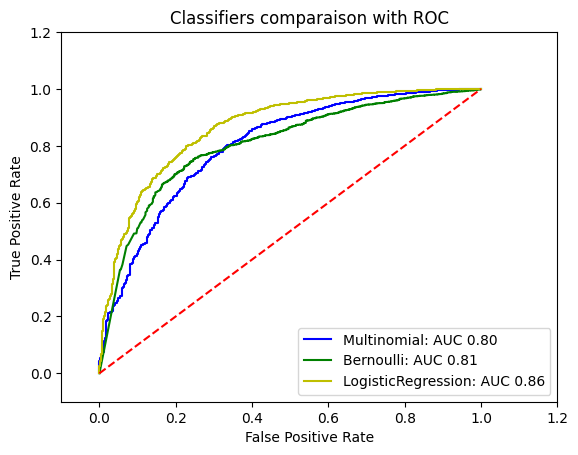

In [18]:
def formatt(x):
    if x == 'neg':
        return 0
    if x == 0:
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    if model not in 'Naive':
        false_positive_rate, true_positive_rate, thresholds = roc_curve(test["senti"].map(vfunc), predicted)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Lets see precision  and recall  of  different  classifiers


![Precision_Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

In [19]:
test.senti = test.senti.replace(["pos" , "neg"] , [True , False] )

/var/folders/gr/klgx05h12r90d11gtqkhqdyr0000gn/T/ipykernel_82154/2228864377.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.senti = test.senti.replace(["pos" , "neg"] , [True , False] )


In [20]:
keys = prediction.keys()
for key in ['Multinomial', 'Bernoulli', 'LogisticRegression']:
    print(" {}:".format(key))
    print(metrics.classification_report(test["senti"], prediction.get(key)>.5, target_names = ["positive", "negative"]))
    print("\n")

 Multinomial:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00       464
    negative       0.93      1.00      0.97      6461

    accuracy                           0.93      6925
   macro avg       0.47      0.50      0.48      6925
weighted avg       0.87      0.93      0.90      6925



 Bernoulli:
              precision    recall  f1-score   support

    positive       0.33      0.17      0.23       464
    negative       0.94      0.97      0.96      6461

    accuracy                           0.92      6925
   macro avg       0.63      0.57      0.59      6925
weighted avg       0.90      0.92      0.91      6925



 LogisticRegression:
              precision    recall  f1-score   support

    positive       0.53      0.35      0.42       464
    negative       0.95      0.98      0.97      6461

    accuracy                           0.94      6925
   macro avg       0.74      0.66      0.69      6925
weighted avg       0.93

/opt/homebrew/Caskroom/miniconda/base/envs/llm-finetune/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/llm-finetune/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/llm-finetune/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

## Let test our classifiers with some handwritten samples


In [21]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(logreg, "The product was good and easy to  use")
test_sample(logreg, "the whole experience was horrible and product is worst")
test_sample(logreg, "product is not good")


Sample estimated as POS: negative prob 0.000000, positive prob 1.000000
Sample estimated as NEG: negative prob 0.999968, positive prob 0.000032
Sample estimated as NEG: negative prob 0.994878, positive prob 0.005122


## Here is predicted valuesof classifiers for check on the basis of review text

In [22]:
check.head(10)



,reviews.rating,reviews.text,reviews.title,reviews.username,Summary_Clean,words,Naive,multi,Bill,log
0,NaN,The Kindle is my first e-ink reader. I own an ...,"Worth the money. Not perfect, but very very go...",Jeffrey Stanley,the kindle is my first e ink reader i own an i...,"[the, kindle, is, my, first, e, ink, reader, i...",neg,pos,neg,pos
1,NaN,"I'm a first-time Kindle owner, so I have nothi...","I Wanted a Dedicated E-Reader, and That's What...",Matthew Coenen,i m a first time kindle owner so i have nothin...,"[i, m, a, first, time, kindle, owner, so, i, h...",neg,pos,neg,pos
2,NaN,UPDATE NOVEMBER 2011:My review is now over a y...,Kindle vs. Nook (updated),Ron Cronovich,update november my review is now over a year o...,"[update, november, my, review, is, now, over, ...",neg,pos,neg,pos
3,NaN,"I'm a first-time Kindle owner, so I have nothi...","I Wanted a Dedicated E-Reader, and That's What...",Matthew Coenen,i m a first time kindle owner so i have nothin...,"[i, m, a, first, time, kindle, owner, so, i, h...",neg,pos,neg,pos
4,NaN,I woke up to a nice surprise this morning: a n...,"Not the perfect do-it-all device, but very clo...",C. Tipton,i woke up to a nice surprise this morning a ne...,"[i, woke, up, to, a, nice, surprise, this, mor...",neg,pos,neg,pos
5,NaN,The Kindle is my first e-ink reader. I own an ...,"Worth the money. Not perfect, but very very go...",Jeffrey Stanley,the kindle is my first e ink reader i own an i...,"[the, kindle, is, my, first, e, ink, reader, i...",neg,pos,neg,pos
6,NaN,UPDATE NOVEMBER 2011:br /br /My review is now ...,Kindle vs. Nook (updated),Ron Cronovich,update november br br my review is now over a ...,"[update, november, br, br, my, review, is, now...",neg,pos,neg,pos
7,NaN,I woke up to a nice surprise this morning: a n...,"Not the perfect do-it-all device, but very clo...",C. Tipton,i woke up to a nice surprise this morning a ne...,"[i, woke, up, to, a, nice, surprise, this, mor...",neg,pos,neg,pos
8,NaN,I use to hate to read but now that I have my K...,Great,D. Tatro,i use to hate to read but now that i have my k...,"[i, use, to, hate, to, read, but, now, that, i...",pos,pos,pos,pos
9,NaN,All of them quit working. There's absolutely n...,I've had 3!,M. Lansford Kindle fave,all of them quit working there s absolutely no...,"[all, of, them, quit, working, there, s, absol...",neg,pos,pos,pos


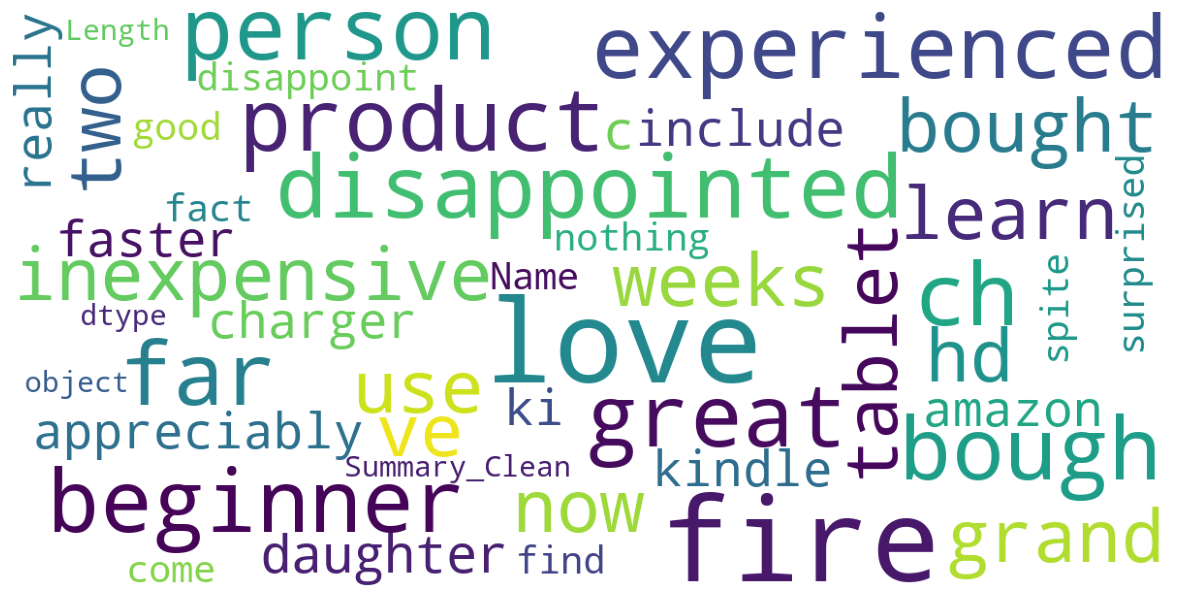

In [23]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
        
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(senti["Summary_Clean"])


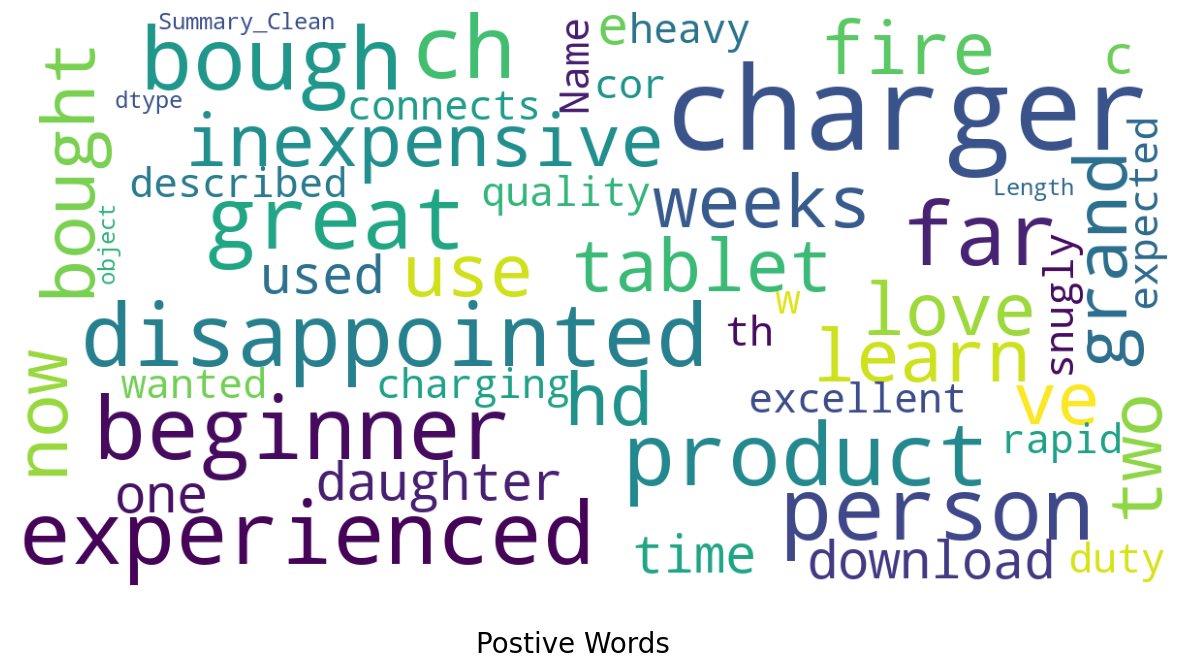

In [24]:
show_wordcloud(senti["Summary_Clean"][senti.senti == "pos"] , title="Postive Words")

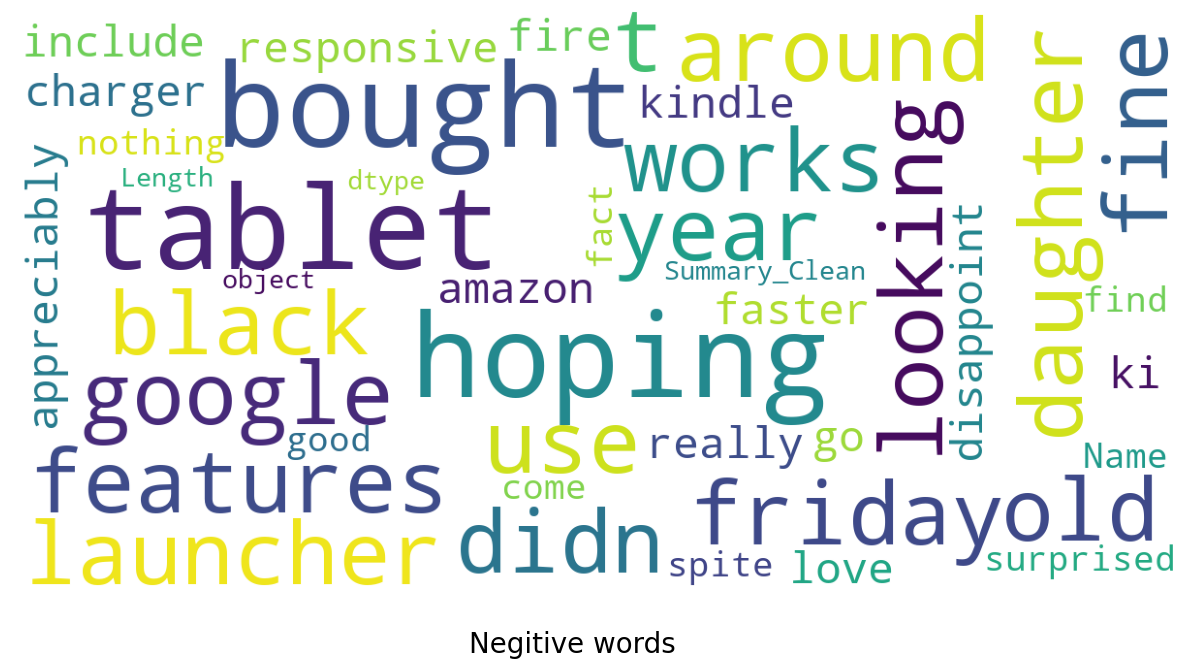

In [25]:
show_wordcloud(senti["Summary_Clean"][senti.senti == "neg"] , title="Negitive words")

In [26]:
# Convert boolean labels to string: True → 'pos', False → 'neg'
train["senti"] = train["senti"].map({True: "pos", False: "neg"})
test["senti"] = test["senti"].map({True: "pos", False: "neg"})


In [27]:
from sklearn.metrics import accuracy_score

# NLTK Naive Bayes
nltk_accuracy = nltk.classify.util.accuracy(classifier, test_naive)

# MultinomialNB
multinomial_accuracy = model1.score(X_test_tfidf, test["senti"])

# BernoulliNB
bernoulli_accuracy = model2.score(X_test_tfidf, test["senti"])

# Logistic Regression
logistic_accuracy = logreg.score(X_test_tfidf, test["senti"])

# Print all together
print("==== Model Accuracy Comparison ====")
print(f"NLTK Naive Bayes Accuracy     : {nltk_accuracy:.4f}")
print(f"MultinomialNB Accuracy        : {multinomial_accuracy:.4f}")
print(f"BernoulliNB Accuracy          : {bernoulli_accuracy:.4f}")
print(f"Logistic Regression Accuracy  : {logistic_accuracy:.4f}")


==== Model Accuracy Comparison ====
NLTK Naive Bayes Accuracy     : 0.5897
MultinomialNB Accuracy        : 0.9330
BernoulliNB Accuracy          : 0.9204
Logistic Regression Accuracy  : 0.9356


In [28]:
import joblib

# Save the model and vectorizer
joblib.dump(logreg, "logistic_model.pkl")
joblib.dump(count_vect, "count_vectorizer.pkl")
joblib.dump(tfidf_transformer, "tfidf_transformer.pkl")


['tfidf_transformer.pkl']